In [ ]:
import numpy as np
import pandas as pd
import ast
import operator

In [ ]:
test = pd.read_csv('/content/humanitarian_SMALL_5classes_TEXT+IMGPRED (4).tsv', sep='\t')

In [ ]:
test.head()

,event_name,tweet_id,image_id,tweet_text,image,label_text,label_image,split,pred_label_text,pred_proba_text,codeorder_label_text,pred_proba_img,pred_label_img
0,hurricane_harvey,9.059523e+17,905952332923338752_0,<MENTION> has a great event tomorrow for both...,data_image/hurricane_harvey/8_9_2017/905952332...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,TEST,rescue_volunteering_or_donation_effort,"['0.01001685', '0.04121619', '0.36350593', '0....","['infrastructure_and_utility_damage', 'other_r...","[0.016998926177620888, 0.3229636549949646, 0.5...",not_humanitarian
1,mexico_earthquake,9.120221e+17,912022130396672000_0,now <MENTION> also carlo surf band at 8pm <HAS...,data_image/mexico_earthquake/24_9_2017/9120221...,not_humanitarian,not_humanitarian,TEST,not_humanitarian,"['0.00768627', '0.05296155', '0.9199777', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.000817299063783139, 0.6597933769226074, 0.2...",other_relevant_information
2,hurricane_maria,9.277589e+17,927758858776465408_0,guaynabo resident efrain diaz stands by a brid...,data_image/hurricane_maria/7_11_2017/927758858...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,TEST,infrastructure_and_utility_damage,"['0.59517187', '0.1377205', '0.14931679', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.21951517462730408, 0.04029771685600281, 0.2...",rescue_volunteering_or_donation_effort
3,hurricane_harvey,9.076543e+17,907654309587779584_0,after harvey irma leaves its own trail of dest...,data_image/hurricane_harvey/12_9_2017/90765430...,other_relevant_information,other_relevant_information,TEST,infrastructure_and_utility_damage,"['0.60781467', '0.18188037', '0.10388581', '0....","['infrastructure_and_utility_damage', 'other_r...","[0.01850350759923458, 0.571672260761261, 0.374...",other_relevant_information
4,hurricane_maria,9.137456e+17,913745586104528898_0,dawn just won 400 and were gonna match the amo...,data_image/hurricane_maria/29_9_2017/913745586...,not_humanitarian,not_humanitarian,TEST,not_humanitarian,"['0.00788021', '0.05330051', '0.8445104', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.0006032107048667967, 0.4620007276535034, 0....",not_humanitarian


In [ ]:
label_list = test.codeorder_label_text[0]
label_list = ast.literal_eval(label_list)
print(type(label_list))
print(label_list)


<class 'list'>
['infrastructure_and_utility_damage', 'other_relevant_information', 'not_humanitarian', 'rescue_volunteering_or_donation_effort', 'affected_individuals']


## Add

In [ ]:
def add_label(prob_img, prob_text):
  prob_img = ast.literal_eval(prob_img)
  prob_text = ast.literal_eval(prob_text)
  prob_text = [float(i) for i in prob_text]

  add_prob = list(map(operator.add,prob_img,prob_text))
  add_index = np.argmax(add_prob)

  label = label_list[add_index]

  return label

## Max

In [ ]:
def max_label(prob_img, prob_text):
  prob_img = ast.literal_eval(prob_img)
  prob_text = ast.literal_eval(prob_text)
  prob_text = [float(i) for i in prob_text]
  max_index = 0

  max_text = np.argmax(prob_text)
  max_img = np.argmax(prob_img)

  if prob_text[max_text]>= prob_img[max_img]:
    max_index = max_text
  else:
    max_index = max_img

  return label_list[max_index]



In [ ]:
# test example
x = test.pred_proba_img[0]
y = test.pred_proba_text[0]
print(x)
print(y)
print(max_label(x,y))
print(add_label(x,y))

[0.016998926177620888, 0.3229636549949646, 0.5146282315254211, 0.13299460709095, 0.012414569035172462]
['0.01001685', '0.04121619', '0.36350593', '0.5653406', '0.01992042']
rescue_volunteering_or_donation_effort
not_humanitarian


## Get final labels

In [ ]:
def isNaN(string):
   return string != string
print(isNaN("hello"))
print(isNaN(np.nan))

False
True


In [ ]:
new_test = test.copy(deep=True)
new_test['label_add']=''
new_test['label_max']=''


for index in new_test.index:
  x = new_test.loc[index,'pred_proba_img']
  y = new_test.loc[index,'pred_proba_text']
  if isNaN(x):
    x = str([0,0,0,0,0])
  if isNaN(y):
    y = '[0,0,0,0,0]'

  new_test.loc[index,'label_add'] = add_label(x, y)
  new_test.loc[index,'label_max'] = max_label(x, y)


new_test.head()
  

# test['final_label'] = final_label(test.pred_proba_img,test.pred_proba_text)
# new_test.loc[955,'final_label']

,event_name,tweet_id,image_id,tweet_text,image,label_text,label_image,split,pred_label_text,pred_proba_text,codeorder_label_text,pred_proba_img,pred_label_img,label_add,label_max
0,hurricane_harvey,9.059523e+17,905952332923338752_0,<MENTION> has a great event tomorrow for both...,data_image/hurricane_harvey/8_9_2017/905952332...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,TEST,rescue_volunteering_or_donation_effort,"['0.01001685', '0.04121619', '0.36350593', '0....","['infrastructure_and_utility_damage', 'other_r...","[0.016998926177620888, 0.3229636549949646, 0.5...",not_humanitarian,not_humanitarian,rescue_volunteering_or_donation_effort
1,mexico_earthquake,9.120221e+17,912022130396672000_0,now <MENTION> also carlo surf band at 8pm <HAS...,data_image/mexico_earthquake/24_9_2017/9120221...,not_humanitarian,not_humanitarian,TEST,not_humanitarian,"['0.00768627', '0.05296155', '0.9199777', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.000817299063783139, 0.6597933769226074, 0.2...",other_relevant_information,not_humanitarian,not_humanitarian
2,hurricane_maria,9.277589e+17,927758858776465408_0,guaynabo resident efrain diaz stands by a brid...,data_image/hurricane_maria/7_11_2017/927758858...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,TEST,infrastructure_and_utility_damage,"['0.59517187', '0.1377205', '0.14931679', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.21951517462730408, 0.04029771685600281, 0.2...",rescue_volunteering_or_donation_effort,infrastructure_and_utility_damage,infrastructure_and_utility_damage
3,hurricane_harvey,9.076543e+17,907654309587779584_0,after harvey irma leaves its own trail of dest...,data_image/hurricane_harvey/12_9_2017/90765430...,other_relevant_information,other_relevant_information,TEST,infrastructure_and_utility_damage,"['0.60781467', '0.18188037', '0.10388581', '0....","['infrastructure_and_utility_damage', 'other_r...","[0.01850350759923458, 0.571672260761261, 0.374...",other_relevant_information,other_relevant_information,infrastructure_and_utility_damage
4,hurricane_maria,9.137456e+17,913745586104528898_0,dawn just won 400 and were gonna match the amo...,data_image/hurricane_maria/29_9_2017/913745586...,not_humanitarian,not_humanitarian,TEST,not_humanitarian,"['0.00788021', '0.05330051', '0.8445104', '0.0...","['infrastructure_and_utility_damage', 'other_r...","[0.0006032107048667967, 0.4620007276535034, 0....",not_humanitarian,not_humanitarian,not_humanitarian


In [ ]:
new_test.to_csv('humanitarian_SMALL_5classes_withFusion.tsv',sep='\t',index=False)

In [ ]:
! zip humanitarian_SMALL_5classes_withFusion.zip humanitarian_SMALL_5classes_withFusion.tsv

  adding: humanitarian_SMALL_5classes_withFusion.tsv (deflated 78%)


## Get scores

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [ ]:
! unzip '/content/humanitarian_SMALL_5classes_withFusion.zip'
df_fusion = pd.read_csv('/content/humanitarian_SMALL_5classes_withFusion.tsv', sep='\t')

Archive:  /content/humanitarian_SMALL_5classes_withFusion.zip
  inflating: humanitarian_SMALL_5classes_withFusion.tsv  


In [ ]:
label_order = df_fusion.codeorder_label_text.values[0][1:-1].replace("'", "").split(',')
label_dict = {}
for i in range(len(label_order)):
  label_dict[label_order[i].strip()] = i

print(label_dict)

{'infrastructure_and_utility_damage': 0, 'other_relevant_information': 1, 'not_humanitarian': 2, 'rescue_volunteering_or_donation_effort': 3, 'affected_individuals': 4}


In [ ]:
df_fusion.drop(index=955, inplace=True)

In [ ]:
true_vals = [label_dict[l] for l in df_fusion.label_text.values]
pred_add_vals = [label_dict[l] for l in df_fusion.label_add.values]
pred_max_vals = [label_dict[l] for l in df_fusion.label_max.values]
labels = list(label_dict.keys())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_confmat(y_true, y_pred, labels):
  conf_mat = confusion_matrix(y_true, y_pred)

  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=labels, yticklabels=labels)

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

                                        precision    recall  f1-score   support

     infrastructure_and_utility_damage     0.9545    0.5185    0.6720        81
            other_relevant_information     0.8786    0.7702    0.8209       235
                      not_humanitarian     0.7769    0.9325    0.8476       504
rescue_volunteering_or_donation_effort     0.7700    0.6111    0.6814       126
                  affected_individuals     0.0000    0.0000    0.0000         9

                              accuracy                         0.8063       955
                             macro avg     0.6760    0.5665    0.6044       955
                          weighted avg     0.8087    0.8063    0.7962       955



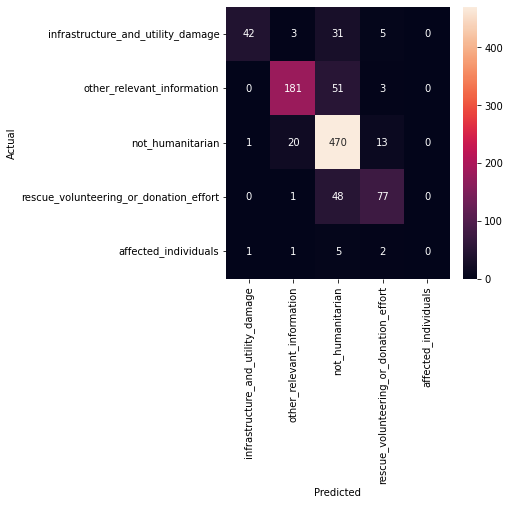

In [ ]:
print(classification_report(true_vals, pred_add_vals, target_names=list(label_dict.keys()), zero_division=0, digits=4))
show_confmat(true_vals, pred_add_vals, labels)

                                        precision    recall  f1-score   support

     infrastructure_and_utility_damage     0.9286    0.4815    0.6341        81
            other_relevant_information     0.8696    0.7660    0.8145       235
                      not_humanitarian     0.7802    0.9226    0.8455       504
rescue_volunteering_or_donation_effort     0.7182    0.6270    0.6695       126
                  affected_individuals     0.0000    0.0000    0.0000         9

                              accuracy                         0.7990       955
                             macro avg     0.6593    0.5594    0.5927       955
                          weighted avg     0.7992    0.7990    0.7887       955



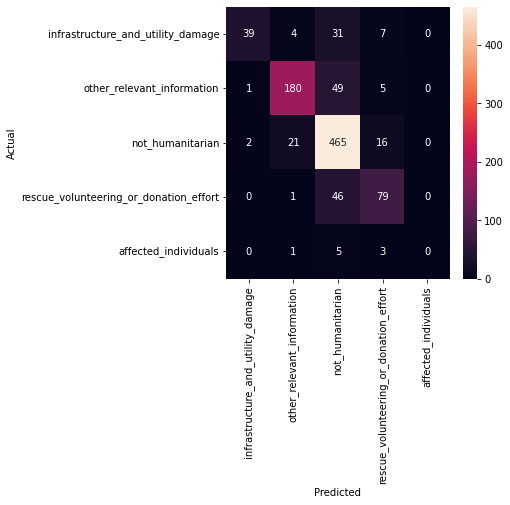

In [ ]:
print(classification_report(true_vals, pred_max_vals, target_names=list(label_dict.keys()), zero_division=0, digits=4))
show_confmat(true_vals, pred_max_vals, labels)